In [1]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
crime_data = pd.read_csv('C:/Users/Sandi/Downloads/Crime1.csv',
                           sep= ',', header= 0)
columnsTitles=['Category', 'Dates', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y']
crime_data=crime_data.reindex(columns=columnsTitles)
crime_data= crime_data[:3000]
# new data frame with split value columns 
new = crime_data["Dates"].str.split(" ", n = 1, expand = True) 
# making seperate date column from Dates Column 
crime_data["Date"]= new[0] 
# making seperate time column from Dates Column 
crime_data["Time"]= new[1] 
# Dropping old Dates columns 
crime_data.drop(columns =["Dates"], inplace = True) 

In [2]:
#Mapping string type columns to number/int type.

crime_data['category_id'] = crime_data['Category'].factorize()[0]
crime_data['Date_id'] = crime_data['Date'].factorize()[0]
crime_data['Time_id'] = crime_data['Time'].factorize()[0]
crime_data['DayOfWeek_id'] = crime_data['DayOfWeek'].factorize()[0]
crime_data['PdDistrict_id'] = crime_data['PdDistrict'].factorize()[0]
crime_data['Resolution_id'] = crime_data['Resolution'].factorize()[0]
crime_data['Address_id'] = crime_data['Address'].factorize()[0]
columnsTitles=['Category', 'category_id', 'Date', 'Date_id','Time','Time_id', 'Descript', 'DayOfWeek', 'DayOfWeek_id','PdDistrict','PdDistrict_id', 'Resolution', 'Resolution_id','Address','Address_id', 'X', 'Y']
crime_data=crime_data.reindex(columns=columnsTitles)

print(crime_data.head())

         Category  category_id       Date  Date_id   Time  Time_id  \
0        WARRANTS            0  5/13/2015        0  23:53        0   
1  OTHER OFFENSES            1  5/13/2015        0  23:53        0   
2  OTHER OFFENSES            1  5/13/2015        0  23:33        1   
3   LARCENY/THEFT            2  5/13/2015        0  23:30        2   
4   LARCENY/THEFT            2  5/13/2015        0  23:30        2   

                       Descript  DayOfWeek  DayOfWeek_id PdDistrict  \
0                WARRANT ARREST  Wednesday             0   NORTHERN   
1      TRAFFIC VIOLATION ARREST  Wednesday             0   NORTHERN   
2      TRAFFIC VIOLATION ARREST  Wednesday             0   NORTHERN   
3  GRAND THEFT FROM LOCKED AUTO  Wednesday             0   NORTHERN   
4  GRAND THEFT FROM LOCKED AUTO  Wednesday             0       PARK   

   PdDistrict_id      Resolution  Resolution_id                    Address  \
0              0  ARREST, BOOKED              0         OAK ST / LAGUNA ST

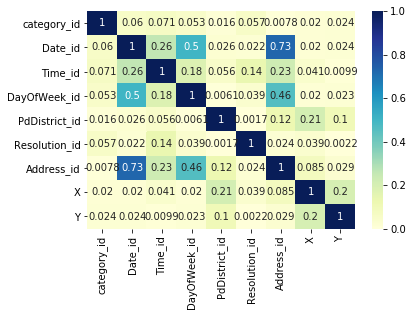

In [3]:
import seaborn as sns
correlations = crime_data[crime_data.columns].corr(method='pearson')
sns.heatmap(abs(correlations), cmap="YlGnBu", annot = True)

In [4]:
# we see that there's not much correlation between the other columns and the category so we would consider the other approach i.e., use "Descript" column from
# Crime1.csv and search for keywords specific to the crime

category_id_df = crime_data[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(crime_data['Descript']).toarray()
labels = crime_data['category_id']
features.shape

N = 2
for Category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Category))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))
  

# 'ARSON':
  . Most correlated unigrams:
       . attempted
       . arson
  . Most correlated bigrams:
       . theft locked
       . grand theft
# 'ASSAULT':
  . Most correlated unigrams:
       . assault
       . battery
  . Most correlated bigrams:
       . threats life
       . aggravated assault
# 'BRIBERY':
  . Most correlated unigrams:
       . theft
       . victim
  . Most correlated bigrams:
       . theft locked
       . grand theft
# 'BURGLARY':
  . Most correlated unigrams:
       . burglary
       . entry
  . Most correlated bigrams:
       . forcible entry
       . unlawful entry
# 'DISORDERLY CONDUCT':
  . Most correlated unigrams:
       . peace
       . disturbing
  . Most correlated bigrams:
       . grand theft
       . disturbing peace
# 'DRIVING UNDER THE INFLUENCE':
  . Most correlated unigrams:
       . influence
       . driving
  . Most correlated bigrams:
       . influence alcohol
       . driving influence
# 'DRUG/NARCOTIC':
  . Most correlated unigrams:
 

In [5]:
# spliting the training and testing sets
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, crime_data.index, test_size=0.2, random_state=0)

print('Data size of training set:',len(X_train))
print('Data size of testing set:',len(X_test))

Data size of training set: 2400
Data size of testing set: 600


In [6]:
#Linear SVC
lsvc = LinearSVC()
y_pred_LSVC = lsvc.fit(X_train, y_train).predict(X_test)
print("Accuracy of SVC: ", metrics.accuracy_score(y_test,y_pred_LSVC)*100)

Accuracy of SVC:  98.0


In [7]:
#DTC
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 0,
                               min_samples_split =3)
clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 0,
                               min_samples_split =3)
y_pred_DTC_gini = clf_gini.fit(X_train, y_train).predict(X_test)
y_pred_DTC_entropy = clf_entropy.fit(X_train, y_train).predict(X_test)
print("Accuracy of DTC (gini): ", metrics.accuracy_score(y_test,y_pred_DTC_gini)*100)
print("Accuracy of DTC (entropy):", metrics.accuracy_score(y_test,y_pred_DTC_entropy)*100)


Accuracy of DTC (gini):  96.66666666666667
Accuracy of DTC (entropy): 97.33333333333334


In [8]:
#KNN
knn = KNeighborsClassifier(n_neighbors=25)
y_pred_knn = knn.fit(X_train, y_train).predict(X_test)
print("Accuracy of KNN:",metrics.accuracy_score(y_test, y_pred_knn)*100)

Accuracy of KNN: 94.83333333333334


In [9]:
#NAIVE BAYES
gnb = GaussianNB()
mnb = MultinomialNB()
cnb = ComplementNB()

y_pred_gnb = gnb.fit(X_train, y_train).predict(X_test)
y_pred_mnb = mnb.fit(X_train, y_train).predict(X_test)
y_pred_cnb = cnb.fit(X_train, y_train).predict(X_test)

print("Accuracy of GNB:",metrics.accuracy_score(y_test, y_pred_gnb)*100)
print("Accuracy of MNB:",metrics.accuracy_score(y_test, y_pred_mnb)*100)
print("Accuracy of CNB:",metrics.accuracy_score(y_test, y_pred_cnb)*100)

Accuracy of GNB: 92.83333333333333
Accuracy of MNB: 95.16666666666667
Accuracy of CNB: 96.5


In [10]:
#Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
y_pred_rfc = rfc.fit(X_train, y_train).predict(X_test)
print("Accuracy of Random Forest Classifier:",metrics.accuracy_score(y_test, y_pred_rfc)*100)

Accuracy of Random Forest Classifier: 58.166666666666664
